In [12]:
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    
#import potrebnih biblioteka

import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 107, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)
def remove_noise(image):
     # strukturni element 3x3 blok
    return dilate(erode(image))
#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(100,80), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]


In [13]:
# TODO 7
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=100*80, activation='sigmoid')) #128 ,edjusloj i 28*28 ulaz to treba namontirati
    ann.add(Dense(5, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=1500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [14]:
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 200x200 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 40000 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

In [15]:
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [16]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

In [17]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

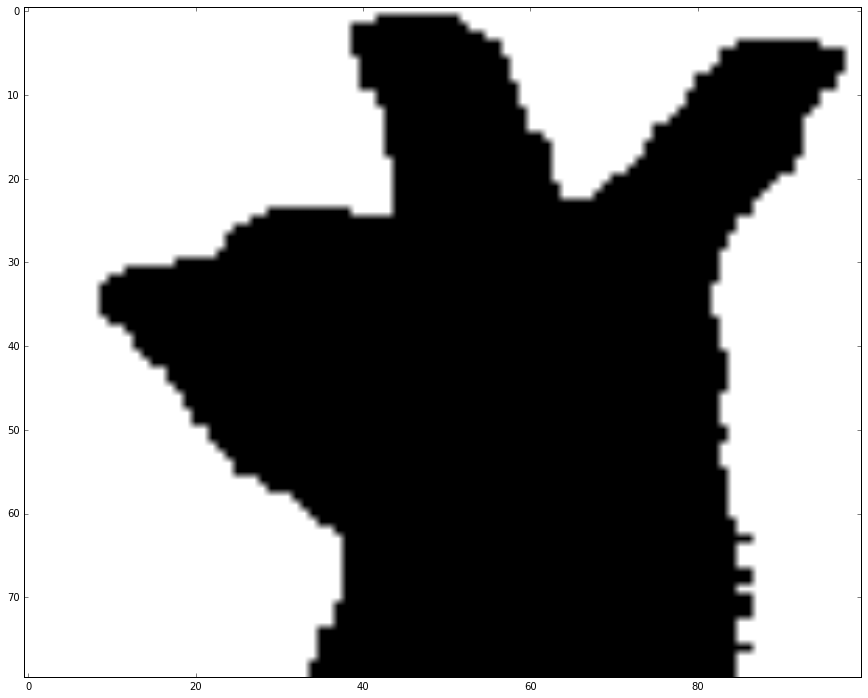

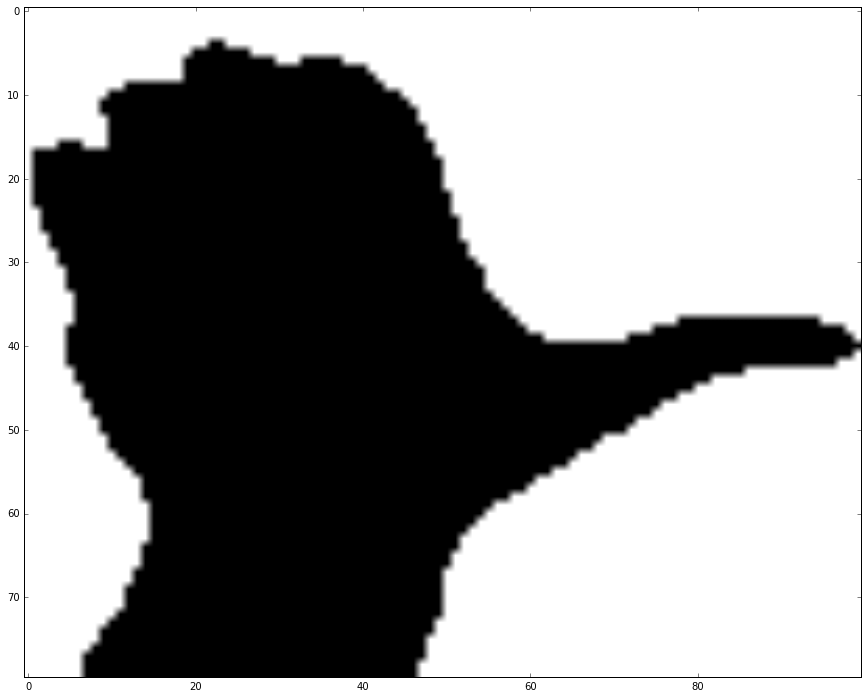

In [18]:
obucavanje = []

image_color = load_image('images/capture158.jpg')
img = image_bin(image_gray(image_color))

image_color1 = load_image('images/capture166.jpg')
img1 = image_bin(image_gray(image_color1))

image_color2 = load_image('images/capture242.jpg')
img2 = image_bin(image_gray(image_color2))

image_color3 = load_image('images/capture168.jpg')
img3 = image_bin(image_gray(image_color3))

image_color4 = load_image('images/capture138.jpg')
img4 = image_bin(image_gray(image_color4))



slike = {}
slike[0] = img
slike[1] = img1
slike[2] = img2
slike[3] = img3
slike[4] = img4


sorted_regions_dic = collections.OrderedDict(sorted(slike.items()))
obucavanje = sorted_regions_dic.values()

display_image(obucavanje[0])
plt.figure()
display_image(obucavanje[1])

In [19]:
alphabet = ["a","b","c","d"," "]
inputs = prepare_for_ann(obucavanje) 
outputs = convert_output(alphabet)
 
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [20]:
result = ann.predict(np.array(inputs[:], np.float32))
print result
print display_result(result, alphabet)

[[ 0.98062694  0.01015547  0.01167857  0.0135606   0.01205887]
 [ 0.01155457  0.9815287   0.01169702  0.01047122  0.01070084]
 [ 0.01019642  0.01123965  0.98022538  0.01092074  0.01008648]
 [ 0.01382541  0.01166484  0.01315686  0.98000377  0.01225232]
 [ 0.00996805  0.01034874  0.01126683  0.01046209  0.98132527]]
['a', 'b', 'c', 'd', ' ']


In [21]:
import re, collections

def words123(text): return re.findall('[a-z]+', text.lower()) 

def train123(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

NWORDS = train123(words123(file('C:/Users/Home/Desktop/ProjekatSoft/IvanKvadratici/images/big.txt').read()))

alphabet123 = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
    splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [a + b[1:] for a, b in splits if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
    replaces   = [a + c + b[1:] for a, b in splits for c in alphabet123 if b]
    inserts    = [a + c + b     for a, b in splits for c in alphabet123]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words): return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return max(candidates, key=NWORDS.get)

In [22]:
import cv2
import numpy as np
import math
cap = cv2.VideoCapture(0)
bla=0
ci=0
tekst=['bla']
rec=[]
flag=False
br=0
brojac=0
while(cap.isOpened()):
    ret, img = cap.read()
    cv2.rectangle(img,(300,300),(100,100),(0,255,0),0)
    crop_img = img[100:300, 100:300]
    
    slika=remove_noise(image_bin(image_gray(crop_img)))
    
    imga, contours, hierarchy = cv2.findContours(invert(slika.copy()), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)>0:
            max_area = -1
            for i in range(len(contours)):
                cnt=contours[i]
                area = cv2.contourArea(cnt)
                if(area>max_area):
                        max_area=area
                        ci=i

            cnt=contours[ci]
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(crop_img,(x,y),(x+w,y+h),(0,0,255),0)
            borko=resize_region(slika[y:y+h,x:x+w])
    else:
        borko=slika[0:80,0:100]
    
    
    k = cv2.waitKey(10)
    if k == 32:
        string='images2/capture'+str(bla)+'.jpg'
        cv2.imwrite(string,slika)
        bla=bla+1
        #break
    

    cv2.imshow("slika krop",crop_img)
    cv2.imshow("slika kont",imga)
    
    
    
    cv2.imshow("slika treshhold",slika)
    s={}
    s[0] = borko
    
    
    
    o = s.values()
    inputs_test = prepare_for_ann(o)
    results_test = ann.predict(np.array(inputs_test, np.float32))
    #print results_test
    bla=np.array(results_test[0])
    
        
    if (max(bla)>0.85)&(flag==False):
        tekst.append(display_result(results_test,alphabet)[0])
        
        if (tekst[-2]==tekst[-1]):
            brojac=brojac+1
            if (brojac<60):
                
                
                tekst.append(display_result(results_test,alphabet)[0])
                cv2.putText(img,":"+str(display_result(results_test,alphabet)[0])+":", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
                
            elif brojac==60:
                rec.append(display_result(results_test,alphabet)[0])
                
                if rec[-1]==" ":
                    word= "".join(str(x) for x in rec)
                
                    recnik=correct(word)
                    rec=[]
                    flag=True
                    
                    
           
            elif (brojac>=60)&(brojac<90):
                cv2.putText(img,"Prepoznao sam"+" "+str(display_result(results_test,alphabet)[0]), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
            elif brojac>=90:
                brojac=0
                tekst=[]
                tekst.append(display_result(results_test,alphabet)[0])
                
                    
                    
            
        
        else:
            brojac=0
            tekst=[]
            tekst.append(display_result(results_test,alphabet)[0])
        #print display_result(results_test,alphabet)
    else:
        cv2.putText(img,"", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
    if flag==True:
            br=br+1
            if br<30:
                cv2.putText(img,"Rec je "+str(recnik), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            else:
                br=0
                flag=False
    
    
    cv2.imshow("slika",img)
    
    k = cv2.waitKey(10)
    if k == 27:
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
#print rec